In [149]:
# import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model



## Importing Rice Price Data and Data Cleaning

### Domain Insights

To better understand the dynamics of the global rice market, we focus on key factors that influence rice prices and their fluctuations.

- **White Rice 5%**: This variety should be the main focus for analysis as it accounts for **60-70% of the global rice market**. It is a staple rice variety, widely traded and a good indicator of broader rice market trends.
  
- **Key Countries to Analyze**: In this analysis, we will look at **White Rice 5% prices** from major rice-exporting countries, specifically:
  - **Thailand**
  - **Vietnam**
  - **Burma**
  - **Pakistan**
  - **India**
  
- **Supply and Demand Factors**:
  - **Supply**: Affected by the yield from major rice-producing countries, weather patterns, and government policies.
  - **Demand**: Driven by both global consumption and strategic stockpiling by importing nations, especially during times of crisis.

- **Influencing Variables**:
  - **Weather**: Seasonal factors such as temperature and precipitation play a critical role in determining rice yield and supply.
  - **Exchange Rates**: Exchange rates influence the competitiveness of rice exports. A weaker currency can make exports more attractive to international buyers.
  - **Government and Politics**: Government interventions—such as export restrictions, minimum price settings, and bans—can significantly affect the supply of rice in the global market. For example, **India**, the world’s largest rice exporter, imposed restrictions on exports due to high domestic inflation. This benefitted Thailand as it faced less competition, reducing global supply and increasing demand for Thai rice, thereby driving up prices.
  - **Local Economy**: Economic conditions in both exporting and importing countries can affect both supply and demand. Strong local economies may support higher exports, while economic crises or inflation can lead to export restrictions or bans.
  - **Production**: Agricultural productivity and technological improvements in rice farming influence the supply and overall market availability of rice.

- **Price Units**: The dataset reports rice prices in **USD per metric ton (USD/MT)** based on **Free On Board (FOB) Pricing**, which refers to the price at the point of export before additional costs such as shipping and insurance are added. This is a standard international price indicator and allows us to compare prices across countries.

(more work on other country and other potential predictors such as government and politics will be performed in the final assignment)


## Data Cleaning and Feature Transformation (Can collapse)

In [288]:
# import the data
df = pd.read_excel('../data/Thai export rice prices 200-2024 (FOB).xlsx',
                    skiprows = 1, usecols = 'B:H', sheet_name = 0)
df.tail()

,date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%
801,11 Sep 24,33.41,1052,578.0,473.0,856,587
802,19 Sep 24,33.05,1110,575.0,478.0,896,588
803,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,NaN,NaN,ข้าวหอมมะลิ 100%,NaN,NaN,ข้าวเหนียวนาปี,ข้าวนึ่งสีอ่อน


In [289]:
# drop last 3 rows
df.drop(index = [803,804,805], inplace=True)
df.tail()

,date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%
798,21 Aug 24,33.99,988,589.0,467.0,841,598
799,28 Aug 24,33.74,1011,602.0,474.0,833,608
800,4 Sep 24,33.97,1034,598.0,471.0,842,604
801,11 Sep 24,33.41,1052,578.0,473.0,856,587
802,19 Sep 24,33.05,1110,575.0,478.0,896,588


In [290]:
# check for missing values
df.isna().sum()

date                           0
Ex Rate (sight bill)           0
Thai Hom Mali Rice Grade B     1
White Rice 5%                  0
White Broken Rice A.1 Super    0
White Glutinous Rice 10%       0
Parboiled Rice 100%            0
dtype: int64

In [291]:
# check and remove the row as there is 802 observation and only 1 missing value
df[df['Thai Hom Mali Rice Grade B'].isna()]
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(columns = ['index'], inplace=True)
df.columns.name = None
df


,date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%
0,9 Jan 08,33.05,638,374.0,361.0,558,398
1,16 Jan 08,33.00,657,377.0,365.0,529,404
2,23 Jan 08,32.94,688,387.0,378.0,514,420
3,30 Jan 08,32.86,705,418.0,403.0,510,440
4,5 Feb 08,32.73,732,444.0,429.0,518,466
...,...,...,...,...,...,...,...
797,21 Aug 24,33.99,988,589.0,467.0,841,598
798,28 Aug 24,33.74,1011,602.0,474.0,833,608
799,4 Sep 24,33.97,1034,598.0,471.0,842,604
800,11 Sep 24,33.41,1052,578.0,473.0,856,587


In [292]:
#inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         802 non-null    object 
 1   Ex Rate (sight bill)         802 non-null    float64
 2   Thai Hom Mali Rice Grade B   802 non-null    object 
 3   White Rice 5%                802 non-null    float64
 4   White Broken Rice A.1 Super  802 non-null    float64
 5   White Glutinous Rice 10%     802 non-null    object 
 6   Parboiled Rice 100%          802 non-null    object 
dtypes: float64(3), object(4)
memory usage: 44.0+ KB


In [293]:
# notice that some date is missing the year value, write a function to do this by filling missing year with the year value of neiboring row above
# already account for the fact that for dates with changing year (from end of Dec to start of Jan), the year value will not be missing
for i in range(1, len(df)):
    if len(df.loc[i, 'date'].split()) == 2:  # Check if year is missing
        previous_year = df.loc[i-1, 'date'].split()[-1]  # Get previous row's year
        df.loc[i, 'date'] = f"{df.loc[i, 'date']} {previous_year}"  # Append year
df['date']

0       9 Jan 08
1      16 Jan 08
2      23 Jan 08
3      30 Jan 08
4       5 Feb 08
         ...    
797    21 Aug 24
798    28 Aug 24
799     4 Sep 24
800    11 Sep 24
801    19 Sep 24
Name: date, Length: 802, dtype: object

In [294]:
df.loc[226, 'date'] # there is inconsistent year format

'5 Sep 2012'

In [295]:
# Function to standardize the date format, already ensure all data is after 2000 
def normalize_year_format(date_str):
    # Split the date into components
    date_parts = date_str.split()
    
    # Check if the year is two digits
    if len(date_parts[-1]) == 2:
        date_parts[-1] = '20' + date_parts[-1]
    
    # Return the modified date string
    return ' '.join(date_parts)

# Apply the function to the 'Date' column
df['date'] = df['date'].apply(normalize_year_format)

In [296]:
# manually correct a spelling mistake
df.loc[663, 'date']
df.loc[663, 'date'] = '29 Sep 2021'
df.loc[663, 'date']

'29 Sep 2021'

In [297]:
#change dtypes
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y') 
df['Thai Hom Mali Rice Grade B'] = df['Thai Hom Mali Rice Grade B'].astype('float')
df['White Glutinous Rice 10%'] = df['White Glutinous Rice 10%'].astype('float')
df['Parboiled Rice 100%'] = df['Parboiled Rice 100%'].astype('float')
df.rename(columns = {'date': 'Date'}, inplace=True)
df.dtypes


Date                           datetime64[ns]
Ex Rate (sight bill)                  float64
Thai Hom Mali Rice Grade B            float64
White Rice 5%                         float64
White Broken Rice A.1 Super           float64
White Glutinous Rice 10%              float64
Parboiled Rice 100%                   float64
dtype: object

In [298]:
df.head()

,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%
0,2008-01-09,33.05,638.0,374.0,361.0,558.0,398.0
1,2008-01-16,33.00,657.0,377.0,365.0,529.0,404.0
2,2008-01-23,32.94,688.0,387.0,378.0,514.0,420.0
3,2008-01-30,32.86,705.0,418.0,403.0,510.0,440.0
4,2008-02-05,32.73,732.0,444.0,429.0,518.0,466.0


In [299]:
df.describe()

,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%
count,802,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,2016-04-28 00:41:17.805486080,32.670324,959.093516,490.806733,409.634663,810.291771,507.009975
min,2008-01-09 00:00:00,28.750000,632.000000,350.000000,295.000000,441.000000,359.000000
25%,2012-03-03 12:00:00,31.072500,855.000000,414.000000,341.250000,709.000000,421.000000
50%,2016-05-04 00:00:00,32.450000,963.500000,461.000000,394.000000,793.000000,478.000000
75%,2020-06-22 06:00:00,34.237500,1099.750000,554.500000,453.750000,902.750000,580.750000
max,2024-09-19 00:00:00,37.920000,1263.000000,1022.000000,801.000000,1537.000000,1080.000000
std,NaN,1.923809,154.438987,100.684294,82.397077,184.882693,110.128378


In [300]:
df.nunique() #there are some times where rice price is the same (exactly the same??)

Date                           802
Ex Rate (sight bill)           403
Thai Hom Mali Rice Grade B     403
White Rice 5%                  278
White Broken Rice A.1 Super    245
White Glutinous Rice 10%       434
Parboiled Rice 100%            294
dtype: int64

In [301]:
# stored cleaned data as csv
df.to_csv('../data/cleanedRicePrice.csv', index = False)

### Calculation for Climate Data 

In [302]:
df_monthly = pd.read_csv('../data/monthly_surface_air_temp_precip.csv') #this monthly average is for year 1991-2020
df_monthly

,Category,Average Minimum Surface Air Temperature,Average Mean Surface Air Temperature,Average Maximum Surface Air Temperature,Precipitation
0,Jan,17.67,24.10,30.58,21.85
1,Feb,19.01,25.80,32.64,16.76
2,Mar,21.44,27.93,34.46,46.04
3,Apr,23.44,29.33,35.28,89.79
4,May,23.87,28.77,33.71,190.95
5,Jun,23.88,28.08,32.33,211.21
6,Jul,23.67,27.61,31.59,221.27
7,Aug,23.45,27.33,31.26,271.89
8,Sep,23.09,27.14,31.24,262.13
9,Oct,22.34,26.67,31.05,157.60


In [303]:
df_temp = pd.read_csv('../data/annual_surface_air_temperature.csv')
df_temp = df_temp[df_temp['Category'] >= 2008] # I only have data since 2008 for rice price
df_temp.tail()

,Category,Annual Mean,5-yr smooth
117,2018,26.92,27.22
118,2019,27.49,27.17
119,2020,27.42,27.10
120,2021,26.90,27.01
121,2022,26.78,26.91


In [304]:
df_precip = pd.read_csv('../data/annual_precipitation.csv')
df_precip = df_precip[df_precip['Category'] >= 2008] 
df_precip.tail()

,Category,Annual Mean,5-yr smooth
117,2018,1573.64,1550.48
118,2019,1308.50,1600.20
119,2020,1541.50,1670.30
120,2021,1631.11,1753.66
121,2022,2066.47,1843.74


In [305]:
import pandas as pd

# Ensure the 'Category' column for years is of type integer in df_precip and df_temp
df_precip['Category'] = df_precip['Category'].astype(int)
df_temp['Category'] = df_temp['Category'].astype(int)

# Ensure the 'Category' column for months is of type string in df_monthly
df_monthly['Category'] = df_monthly['Category'].astype(str)

# Define the months array
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Loop through the years and merge them with the monthly data
years = list(range(2008, 2023))

# Initialize an empty list for storing the results
monthly_estimates_list = []

# Calculate the mean of all 12 monthly mean surface temperatures and precipitation to use for adjustment
mean_of_12_months_temp = df_monthly['Average Mean Surface Air Temperature'].mean()
mean_of_12_months_precip = df_monthly['Precipitation'].mean()

for year in years:
    # Direct lookup for the year in the annual data for temperature and precipitation
    annual_mean_temp = df_temp.loc[df_temp['Category'] == year, 'Annual Mean'].values[0]
    annual_mean_precip = df_precip.loc[df_precip['Category'] == year, 'Annual Mean'].values[0]
    
    # Calculate the estimated temperature and precipitation for each month
    for month in months:
        # Direct lookup for the month in the monthly data
        monthly_mean_temp = df_monthly.loc[df_monthly['Category'] == month, 'Average Mean Surface Air Temperature'].values[0]
        monthly_mean_precip = df_monthly.loc[df_monthly['Category'] == month, 'Precipitation'].values[0]
        
        # Adjust the monthly temperature and precipitation based on the annual mean
        estimated_temp = annual_mean_temp * (monthly_mean_temp / mean_of_12_months_temp)
        estimated_precip = annual_mean_precip * (monthly_mean_precip / mean_of_12_months_precip)
        
        # Store the result in the list
        monthly_estimates_list.append({
            'Year': year,
            'Month': month,
            'Estimated Temperature': estimated_temp,
            'Estimated Precipitation': estimated_precip
        })

# Convert the list into a DataFrame
monthly_estimates_df = pd.DataFrame(monthly_estimates_list)

monthly_estimates_df.head(5)
# # Display the result DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Estimated Monthly Temperatures and Precipitation", dataframe=monthly_estimates_df)


,Year,Month,Estimated Temperature,Estimated Precipitation
0,2008,Jan,23.595159,280.667674
1,2008,Feb,25.259548,215.285593
2,2008,Mar,27.344929,591.393121
3,2008,Apr,28.715602,1153.370729
4,2008,May,28.167333,2452.791409


In [306]:
# combine month and year to a new datetime column and assumed the estimation is at the middle of the month
monthly_estimates_df['Date'] = pd.to_datetime(monthly_estimates_df['Year'].astype(str) + '-' + monthly_estimates_df['Month']+ '-15', format='%Y-%b-%d')
monthly_estimates_df.drop(columns=['Year', 'Month'], inplace=True)
monthly_estimates_df = monthly_estimates_df[['Date', 'Estimated Temperature', 'Estimated Precipitation']]
monthly_estimates_df.tail(15)

,Date,Estimated Temperature,Estimated Precipitation
165,2021-10-15,26.717177,1927.863578
166,2021-11-15,25.605214,888.089440
167,2021-12-15,23.952295,464.840203
168,2022-01-15,24.034932,338.623724
169,2022-02-15,25.730342,259.740669
170,2022-03-15,27.854591,713.511956
171,2022-04-15,29.250811,1391.534286
172,2022-05-15,28.692323,2959.276889
173,2022-06-15,28.004186,3273.259344
174,2022-07-15,27.535455,3429.165736


In [307]:
monthly_estimates_df.to_csv('../data/combined_climate_data.csv', index = False)

### Combine the Rice Price df with Climate df

In [308]:
# Set the 'Date' as index in climate_data_df for interpolation
monthly_estimates_df.set_index('Date', inplace=True)

# Merge the rice price data (left) with climate data using the closest match and interpolate
merged_df = pd.merge_asof(df.sort_values('Date'), 
                          monthly_estimates_df.sort_values('Date'), 
                          left_on='Date', 
                          right_index=True, 
                          direction='nearest')
merged_df.tail(10)

,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation
792,2024-07-17,35.68,913.0,584.0,445.0,830.0,592.0,23.845445,588.910824
793,2024-07-24,35.85,909.0,592.0,442.0,812.0,590.0,23.845445,588.910824
794,2024-07-31,35.45,933.0,593.0,447.0,821.0,596.0,23.845445,588.910824
795,2024-08-07,35.39,935.0,580.0,448.0,836.0,589.0,23.845445,588.910824
796,2024-08-14,34.70,969.0,586.0,458.0,853.0,594.0,23.845445,588.910824
797,2024-08-21,33.99,988.0,589.0,467.0,841.0,598.0,23.845445,588.910824
798,2024-08-28,33.74,1011.0,602.0,474.0,833.0,608.0,23.845445,588.910824
799,2024-09-04,33.97,1034.0,598.0,471.0,842.0,604.0,23.845445,588.910824
800,2024-09-11,33.41,1052.0,578.0,473.0,856.0,587.0,23.845445,588.910824
801,2024-09-19,33.05,1110.0,575.0,478.0,896.0,588.0,23.845445,588.910824


In [309]:
#for now no climate data for 2023 and 2024, will remove this line once it is found
merged_df = merged_df[merged_df['Date'].dt.year < 2023]
merged_df.head(10)

,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation
0,2008-01-09,33.05,638.0,374.0,361.0,558.0,398.0,23.595159,280.667674
1,2008-01-16,33.00,657.0,377.0,365.0,529.0,404.0,23.595159,280.667674
2,2008-01-23,32.94,688.0,387.0,378.0,514.0,420.0,23.595159,280.667674
3,2008-01-30,32.86,705.0,418.0,403.0,510.0,440.0,23.595159,280.667674
4,2008-02-05,32.73,732.0,444.0,429.0,518.0,466.0,25.259548,215.285593
5,2008-02-13,32.70,733.0,445.0,430.0,518.0,466.0,25.259548,215.285593
6,2008-02-20,32.32,743.0,457.0,438.0,537.0,510.0,25.259548,215.285593
7,2008-02-27,32.02,749.0,470.0,454.0,542.0,529.0,25.259548,215.285593
8,2008-03-05,31.41,763.0,495.0,479.0,552.0,555.0,27.344929,591.393121
9,2008-03-12,31.36,771.0,544.0,512.0,553.0,604.0,27.344929,591.393121


In [310]:
merged_df.to_csv('../data/combined_price_climate.csv', index = False)

### Add in Other Country 5% white rice price

In [311]:
df_vietnam = pd.read_csv('../data/tidyVietnamPrice.csv')
df_india = pd.read_csv('../data/tidyIndiaPrice.csv')
df_pakistan = pd.read_csv('../data/tidyPakistanPrice.csv')
df_pakistan

,Date,Pakistan_White_5%
0,1997-08-15,376.511278
1,1997-09-15,240.000000
2,1997-10-15,234.000000
3,1997-11-15,239.333333
4,1997-12-15,265.000000
...,...,...
326,2023-10-15,535.000000
327,2023-11-15,575.000000
328,2023-12-15,576.000000
329,2024-01-15,633.000000


In [312]:
df_all_country = df_vietnam.merge(df_india, how ='inner', on = 'Date').merge(df_pakistan, how = 'inner', on = 'Date')
df_all_country.tail(30)

,Date,Vietnam_White_5%,India_White_5%,Pakistan_White_5%
313,2021-09-15,416.0,363.000000,363.0
314,2021-10-15,436.0,354.000000,360.0
315,2021-11-15,430.0,348.000000,360.0
316,2021-12-15,408.0,340.000000,348.0
317,2022-01-15,398.0,347.000000,361.0
318,2022-02-15,400.0,350.000000,353.0
319,2022-03-15,415.0,350.000000,350.0
320,2022-04-15,416.0,343.000000,360.0
321,2022-05-15,419.0,331.000000,367.0
322,2022-06-15,423.0,334.000000,406.0


In [313]:
# Set 'Date' as the index in df_all_country for interpolation
df_all_country['Date'] = pd.to_datetime(df_all_country['Date'])
df_all_country.set_index('Date', inplace=True)

# Sort both DataFrames by 'Date' to prepare for the merge
merged_df = merged_df.sort_values('Date')
df_all_country = df_all_country.sort_values('Date')

# Perform asof merge, finding the nearest date in df_all_country for each date in merged_df
merged_df = pd.merge_asof(merged_df, 
                                df_all_country, 
                                left_on='Date', 
                                right_index=True, 
                                direction='nearest')

# Display the last 10 rows
merged_df.tail(10)


,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Rice 5%,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%
714,2022-10-15,37.91,873.0,429.0,382.0,648.0,434.0,26.597993,2442.430153,429.0,380.0,401.0
715,2022-10-19,37.92,873.0,429.0,382.0,675.0,434.0,26.597993,2442.430153,429.0,380.0,401.0
716,2022-10-26,37.76,876.0,426.0,383.0,678.0,431.0,26.597993,2442.430153,429.0,380.0,401.0
717,2022-11-02,37.39,885.0,427.0,387.0,684.0,435.0,25.490990,1125.129626,438.0,387.0,432.0
718,2022-11-09,36.61,904.0,433.0,395.0,712.0,444.0,25.490990,1125.129626,438.0,387.0,432.0
719,2022-11-23,35.92,865.0,442.0,403.0,698.0,453.0,25.490990,1125.129626,438.0,387.0,432.0
720,2022-11-30,35.10,856.0,456.0,412.0,728.0,464.0,25.490990,1125.129626,438.0,387.0,432.0
721,2022-12-07,34.80,834.0,460.0,415.0,735.0,468.0,23.845445,588.910824,456.0,388.0,456.0
722,2022-12-14,34.36,845.0,465.0,421.0,744.0,474.0,23.845445,588.910824,456.0,388.0,456.0
723,2022-12-21,34.54,840.0,477.0,424.0,740.0,486.0,23.845445,588.910824,456.0,388.0,456.0


In [314]:
merged_df.to_csv('../data/final_merged_df.csv')

In [315]:
# from pandas_profiling import ProfileReport

# # Generate a profile report for final_merged_df
# profile = ProfileReport(final_merged_df, title="Final Merged DataFrame Profile", explorative=True)

# # To display the profile report within Jupyter Notebook
# profile.to_notebook_iframe()

# # Alternatively, save the report as an HTML file
# profile.to_file("final_merged_df_profile.html")
merged_df.columns

Index(['Date', 'Ex Rate (sight bill)', 'Thai Hom Mali Rice Grade B',
       'White Rice 5%', 'White Broken Rice A.1 Super',
       'White Glutinous Rice 10%', 'Parboiled Rice 100%',
       'Estimated Temperature', 'Estimated Precipitation', 'Vietnam_White_5%',
       'India_White_5%', 'Pakistan_White_5%'],
      dtype='object')

In [316]:
df_future = pd.read_csv('../data/cleanedRicePrice.csv')
df_future = df_future[['Date', 'White Rice 5%']]
df_future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           802 non-null    object 
 1   White Rice 5%  802 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.7+ KB


In [317]:
df_future['Date'] = pd.to_datetime(df_future['Date'])
df_future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           802 non-null    datetime64[ns]
 1   White Rice 5%  802 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.7 KB


In [ ]:
future_merged_df = merged_df.merge(df_future, how = 'right', on= 'Date')
future_merged_df.drop(columns = ['White Rice 5%_x'], inplace=True)
future_merged_df.rename(columns = {'White Rice 5%_y': 'White Rice 5%'}, inplace=True)
future_merged_df

,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%,White Rice 5%
0,2008-01-09,33.05,638.0,361.0,558.0,398.0,23.595159,280.667674,390.0,345.633484,390.0,374.0
1,2008-01-16,33.00,657.0,365.0,529.0,404.0,23.595159,280.667674,390.0,345.633484,390.0,377.0
2,2008-01-23,32.94,688.0,378.0,514.0,420.0,23.595159,280.667674,390.0,345.633484,390.0,387.0
3,2008-01-30,32.86,705.0,403.0,510.0,440.0,23.595159,280.667674,390.0,345.633484,390.0,418.0
4,2008-02-05,32.73,732.0,429.0,518.0,466.0,25.259548,215.285593,467.0,345.633484,478.0,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...
797,2024-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,589.0
798,2024-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602.0
799,2024-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,598.0
800,2024-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,578.0


In [328]:
future_merged_df.to_csv('../data/future_rice.csv')

## Visualisation of Current Data
### Rice Price and Exchange Rate Visualisation
 Visualise White Rice 5% (main focus), with exchange rate, and two closely related rice type, Thai Hom Mali Rice Grade B and Parboiled Rice 100% they are closely related due to the fact that thailand are major exporters of these two rice type as well so it might share a relationship
 plus production overlap, shared suppply chain, market demain and government policies can affect all types

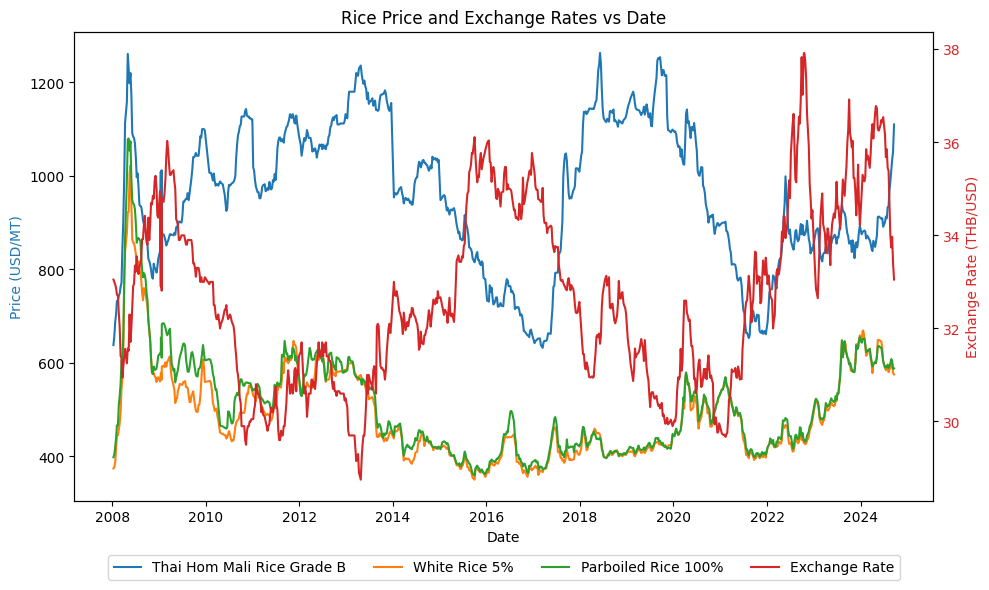

In [319]:
# Use Seaborn to obtain line plot to look at rice price
fig, ax1 = plt.subplots(figsize=(10, 6))
# need to melt df first and use the type as hue
df_select = df[['Date', 'Thai Hom Mali Rice Grade B', 'White Rice 5%', 'Parboiled Rice 100%']]
df_melted = df_select.melt(id_vars = ['Date'], 
                           var_name = 'Type',
                           value_name = 'Value'
                    )
sns.lineplot(data = df_melted, x = 'Date', y = 'Value', hue = 'Type')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD/MT)', color='tab:blue')

ax2 = ax1.twinx()
sns.lineplot(data=df, x='Date', y='Ex Rate (sight bill)', ax=ax2, color='tab:red', label='Exchange Rate', legend=False)
ax2.set_ylabel('Exchange Rate (THB/USD)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
# Combine the legends
lines_1, labels_1 = ax1.get_legend_handles_labels()  # Get handles and labels from the first axis (rice prices)
lines_2, labels_2 = ax2.get_legend_handles_labels()  # Get handles and labels from the second axis (exchange rate)

# Put them together
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.title('Rice Price and Exchange Rates vs Date')
fig.tight_layout()
plt.show()


## Insights from the Visualization of Rice Prices and Exchange Rates

### 1. The 2008-2009 Rice Price Spike:
- There is a **massive spike in rice prices** during 2008-2009. This was caused by the global rice crisis, where major exporters restricted supplies to the market to protect domestic consumers from shortages. Meanwhile, importers scrambled to secure supplies to stabilize their own markets.
- This **crisis led to stockpiling and increased demand** for rice, which further drove prices up. The situation was exacerbated by **export restrictions** in key rice-exporting countries, such as **India and Vietnam**, and **panic buying** from major importing countries like the Philippines. 
- As a result, rice prices increased by **117-149% in the first quarter of 2008**, with global rice markets becoming extremely volatile during this period.

### 2. Similarities Between White Rice 5% and Parboiled Rice 100% Prices:
- The **prices of White Rice 5% and Parboiled Rice 100% are closely aligned** throughout the timeline. This is because both types are produced from the same raw material, **paddy rice**, and share similar production and processing costs.
- Although their end uses may differ, with Parboiled Rice undergoing additional processing, the prices remain similar because their production inputs and demand sources are largely shared.

### 3. Relationship Between Exchange Rates and Rice Prices:
- The **exchange rate (THB/USD)** appears to have a complex, inverse relationship with rice prices at certain points in time. For example, during periods of **weaker Thai Baht** (higher exchange rates), rice prices—particularly **Thai Hom Mali Rice**—seem to increase, likely due to the **increased competitiveness of Thai rice exports**.
- Conversely, when the **exchange rate strengthens** (lower THB/USD), rice prices tend to stabilize or decrease, indicating that domestic and international factors are both influencing price trends.
  
### 4. Thai Hom Mali Rice's Unique Price Movements:
- **Thai Hom Mali Rice Grade B** exhibits more pronounced price fluctuations compared to other rice types, especially after 2016. This could be attributed to its status as a **premium rice variety** with greater sensitivity to **international demand**, which can be influenced by shifts in global markets and currency exchange rates.
- Thai Hom Mali’s premium nature, combined with Thailand's position as a leading exporter of this rice, might make its price more susceptible to changes in **global market conditions** than more standard rice types like White Rice 5%.

### Conclusion:
The visualized data highlights several key points in the relationship between rice prices, exchange rates, and external factors:
- The **2008-2009 food crisis** was a significant global event that led to skyrocketing rice prices due to export restrictions and panic buying.
- **White Rice 5% and Parboiled Rice 100%** have consistently similar pricing due to their common raw material, despite differences in their processing methods.
- **Exchange rate fluctuations** play a critical role in rice pricing, particularly for premium varieties like **Thai Hom Mali Rice**, which shows more sensitivity to shifts in the global market.
- Thailand's position as a major rice exporter means that both **domestic economic factors** (exchange rates) and **international market dynamics** can significantly influence rice price trends.


## Visualisation of Thai 5% rice price compared with other countries

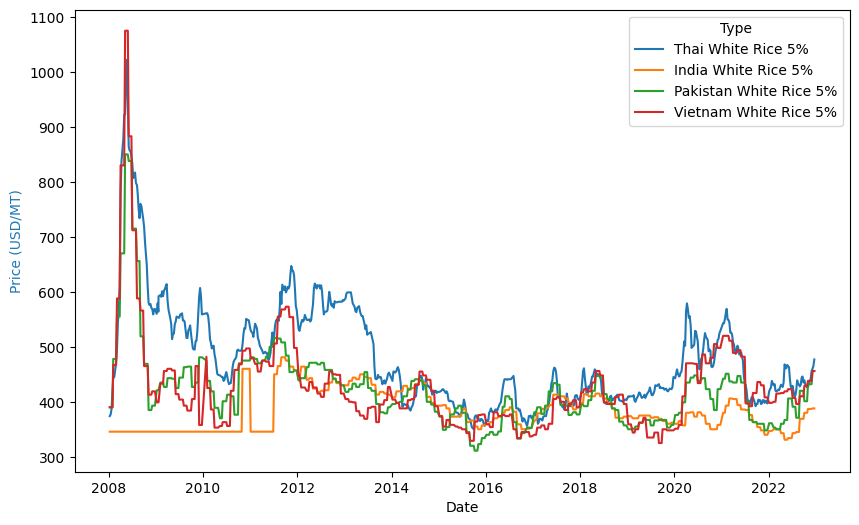

In [320]:
# Select relevant columns and melt the DataFrame
df_select = merged_df[['Date', 'White Rice 5%', 'India_White_5%', 'Pakistan_White_5%', 'Vietnam_White_5%']]
df_melted = df_select.melt(id_vars=['Date'], var_name='Type', value_name='Value')

# Map the original column names to the desired legend labels
type_mapping = {
    'White Rice 5%': 'Thai White Rice 5%',
    'India_White_5%': 'India White Rice 5%',
    'Pakistan_White_5%': 'Pakistan White Rice 5%',
    'Vietnam_White_5%': 'Vietnam White Rice 5%'
}
df_melted['Type'] = df_melted['Type'].map(type_mapping)

# Plotting with Seaborn
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Date', y='Value', hue='Type', ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD/MT)', color='tab:blue')
plt.show()

## Insights 

### 1. Differences in Price Trends Among Rice Types:
- **Thai White Rice 5% consistently has the highest prices** among the four rice types, likely due to **higher quality perception** and **export demand**.
- **Vietnam White Rice 5% and Pakistan White Rice 5%** have more similar pricing, staying consistently lower than Thai rice prices.

### 2. Variations in India White Rice 5%:
- **India White Rice 5%** exhibits inconsistencies in the data, such as a **missing segment from 2010 to 2011** and a noticeable **price increase around 2022**.
- These irregularities could be due to **gaps in data collection**, **changes in export policies**, or **regional market disruptions** affecting India's rice supply and pricing.

### 3. Price Fluctuations Post-2019:
- All rice types exhibit **price increases starting from 2020**, coinciding with global **pandemic-driven supply chain issues** and **rising input costs**.
- The trends suggest global market disruptions affected all rice-exporting countries similarly.

### Conclusion:
The visualization highlights key trends in rice pricing over time, including  **regional differences**, and **post-pandemic price recovery**. The consistent premium for **Thai White Rice 5%** underscores its **market dominance**, while the volatility in prices across all types reflects global economic and supply chain dynamics.


### Climate Data Visualisation 

<Axes: xlabel='Date', ylabel='Estimated Temperature'>

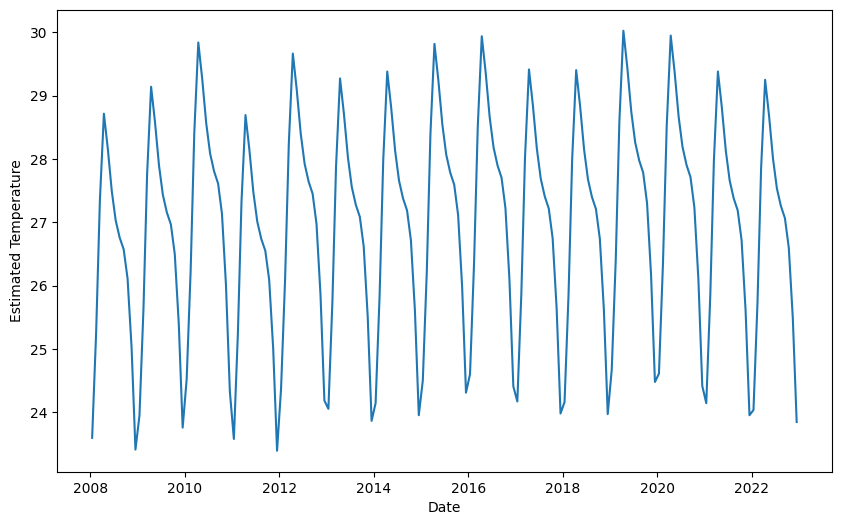

In [321]:
#Temperature
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = monthly_estimates_df, x = 'Date', y = 'Estimated Temperature')

<Axes: xlabel='Date', ylabel='Estimated Precipitation'>

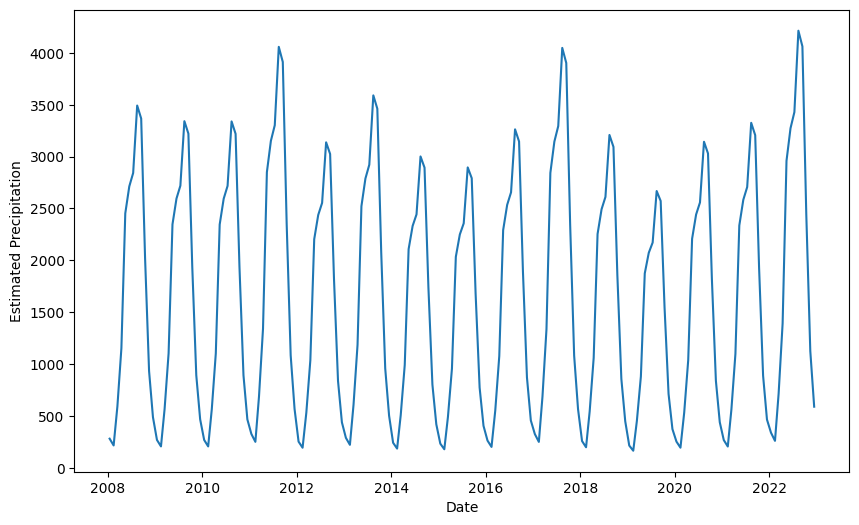

In [322]:
#Precipitation
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = monthly_estimates_df, x = 'Date', y = 'Estimated Precipitation')

# Insights for Temperature and Precipitation Graphs

### 1. Temperature Trend:
- There is a **general increasing trend** in temperature over the years, which is likely due to the effects of **global warming**. The temperature consistently increases year on year, although it appears to have dropped slightly in the last two years.
- In each year, the temperature follows a clear **seasonal cycle**, with peaks around **April**. This makes sense as **April is typically the hottest month in Thailand**, corresponding with the end of the dry season. It is also the time of the **Songkran Festival**, which is celebrated to cool down as the temperature reaches its annual maximum.
  
### 2. Precipitation Pattern:
- The **precipitation pattern** shows significant **annual variation**, with some years having **much higher precipitation** than others, indicated by the varying heights of the spikes in the graph. This randomness could be due to several factors, such as **monsoon intensity** and **regional weather patterns**.
- Precipitation spikes typically occur around **August**, which coincides with the **peak of the monsoon season** in Thailand. During this time, rainfall reaches its highest levels, contributing to the wettest period of the year.

### Conclusion:
- The **seasonality** of both temperature and precipitation is clearly visible in the data, with **temperature peaking in April** and **precipitation spiking in August**, matching Thailand’s known climatic patterns.
- The **long-term upward trend in temperature** is likely an indication of **global warming**, while the **year-to-year fluctuations in precipitation** suggest that rainfall is influenced by more variable factors, such as monsoon strength and other weather systems.


# Perform Dimensionality Reduction (Unsupervised Task)
Two Methods will be explored:
* Principal Component Analysis (PCA)
* Autoencoders

However before this, if we want to predict the future values of rice price, we need to forecast the value of the predictors first. This will be done using SARIMA to be able to capture seasonal component.

In [409]:
# Load the dataset
data = pd.read_csv("../data/future_rice.csv", parse_dates=["Date"])

# Ensure the Date column is the index
data.set_index("Date", inplace=True)
# Identify columns with missing values
columns_to_forecast = data.columns[data.isna().any()].tolist()

columns_to_forecast

['Ex Rate (sight bill)',
 'Thai Hom Mali Rice Grade B',
 'White Broken Rice A.1 Super',
 'White Glutinous Rice 10%',
 'Parboiled Rice 100%',
 'Estimated Temperature',
 'Estimated Precipitation',
 'Vietnam_White_5%',
 'India_White_5%',
 'Pakistan_White_5%']

In [410]:
data.drop(columns={'Unnamed: 0'}, inplace=True)

In [411]:
data

,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%,White Rice 5%
Date,,,,,,,,,,,
2008-01-09,33.05,638.0,361.0,558.0,398.0,23.595159,280.667674,390.0,345.633484,390.0,374.0
2008-01-16,33.00,657.0,365.0,529.0,404.0,23.595159,280.667674,390.0,345.633484,390.0,377.0
2008-01-23,32.94,688.0,378.0,514.0,420.0,23.595159,280.667674,390.0,345.633484,390.0,387.0
2008-01-30,32.86,705.0,403.0,510.0,440.0,23.595159,280.667674,390.0,345.633484,390.0,418.0
2008-02-05,32.73,732.0,429.0,518.0,466.0,25.259548,215.285593,467.0,345.633484,478.0,444.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,589.0
2024-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602.0
2024-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,598.0


In [412]:
def sarima_forecast(time_series, steps=78):
    # Fit SARIMA model (p, d, q) x (P, D, Q, s) - these parameters can be tuned
    model = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  # Weekly seasonality (52 weeks/year)
    result = model.fit(disp=False)
    
    # Forecast future values
    forecast = result.forecast(steps=steps)
    return forecast


In [413]:
# Create a dictionary to store forecasts for each column
forecasts = {}

for col in columns_to_forecast:
    if col in data.columns:
        print(f"Processing column: {col}")
        time_series = data[col].dropna()  # Drop missing values before modeling
        forecasts[col] = sarima_forecast(time_series)

Processing column: Ex Rate (sight bill)


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has bee

Processing column: Thai Hom Mali Rice Grade B


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: White Broken Rice A.1 Super


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: White Glutinous Rice 10%


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: Parboiled Rice 100%


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: Estimated Temperature


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: Estimated Precipitation


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: Vietnam_White_5%


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: India_White_5%


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Processing column: Pakistan_White_5%


/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/Caskroom/miniconda/base/envs/python3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [415]:
forecasts
forecast_df = pd.DataFrame(forecasts)
forecast_df

,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%
724,34.387584,835.327359,428.660424,739.073750,492.140716,23.653770,555.841934,446.789280,386.554746,451.649280
725,34.300375,829.575424,432.179156,737.010421,495.968920,23.644681,616.694428,446.064557,387.465062,451.853572
726,34.326295,831.161068,432.542331,726.072468,501.149639,23.543117,423.147366,446.602136,385.804066,449.092234
727,34.416542,819.527757,432.743922,722.722449,499.811950,23.401002,367.772599,445.578601,386.408220,459.453329
728,34.312646,816.815257,437.230317,721.488283,504.906871,23.388603,352.791777,441.771859,381.482519,457.887865
...,...,...,...,...,...,...,...,...,...,...
797,35.200327,872.186932,466.968326,758.919766,556.861820,24.201279,583.377110,483.718081,393.880022,486.152804
798,35.089356,881.471453,470.282075,751.954861,559.471216,24.232972,584.729313,486.611268,395.375902,489.159509
799,35.078959,876.449610,469.478460,750.776092,554.712782,24.083448,556.842330,487.070352,394.810559,501.167038
800,35.134975,866.304102,468.365859,748.649160,549.901336,24.137569,643.461795,485.262989,394.525624,501.930348


In [417]:
forecast_df.to_csv('../data/forecasted_rice.csv')

In [494]:
forecast_df = pd.read_csv('../data/forecasted_rice.csv')
forecast_df

,Unnamed: 0,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%
0,724,34.387584,835.327359,428.660424,739.073750,492.140716,23.653770,555.841934,446.789280,386.554746,451.649280
1,725,34.300375,829.575424,432.179156,737.010421,495.968920,23.644681,616.694428,446.064557,387.465062,451.853572
2,726,34.326295,831.161068,432.542331,726.072468,501.149639,23.543117,423.147366,446.602136,385.804066,449.092234
3,727,34.416542,819.527757,432.743922,722.722449,499.811950,23.401002,367.772599,445.578601,386.408220,459.453329
4,728,34.312646,816.815257,437.230317,721.488283,504.906871,23.388603,352.791777,441.771859,381.482519,457.887865
...,...,...,...,...,...,...,...,...,...,...,...
73,797,35.200327,872.186932,466.968326,758.919766,556.861820,24.201279,583.377110,483.718081,393.880022,486.152804
74,798,35.089356,881.471453,470.282075,751.954861,559.471216,24.232972,584.729313,486.611268,395.375902,489.159509
75,799,35.078959,876.449610,469.478460,750.776092,554.712782,24.083448,556.842330,487.070352,394.810559,501.167038
76,800,35.134975,866.304102,468.365859,748.649160,549.901336,24.137569,643.461795,485.262989,394.525624,501.930348


In [495]:
#combine the df
df = pd.read_csv('../data/future_rice.csv')
df

,Unnamed: 0,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%,White Rice 5%
0,0,2008-01-09,33.05,638.0,361.0,558.0,398.0,23.595159,280.667674,390.0,345.633484,390.0,374.0
1,1,2008-01-16,33.00,657.0,365.0,529.0,404.0,23.595159,280.667674,390.0,345.633484,390.0,377.0
2,2,2008-01-23,32.94,688.0,378.0,514.0,420.0,23.595159,280.667674,390.0,345.633484,390.0,387.0
3,3,2008-01-30,32.86,705.0,403.0,510.0,440.0,23.595159,280.667674,390.0,345.633484,390.0,418.0
4,4,2008-02-05,32.73,732.0,429.0,518.0,466.0,25.259548,215.285593,467.0,345.633484,478.0,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,797,2024-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,589.0
798,798,2024-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602.0
799,799,2024-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,598.0
800,800,2024-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,578.0


In [496]:
df2 = df.copy()

In [497]:
for i in columns_to_forecast:
    print("Original df[i]:")
    print(df[i].dropna())
    print("Forecast df[i]:")
    print(forecast_df[i])
    
    # Align the indice
    combined = pd.concat([df[i].dropna(), forecast_df[i]])
    combined = combined.reset_index(drop=True)
    print(combined)
    # Combine and drop NaN
    df2[i] = combined
    
    # print("Updated df[i]:")
    # print(df[i])

df2

Original df[i]:
0      33.05
1      33.00
2      32.94
3      32.86
4      32.73
       ...  
719    35.92
720    35.10
721    34.80
722    34.36
723    34.54
Name: Ex Rate (sight bill), Length: 724, dtype: float64
Forecast df[i]:
0     34.387584
1     34.300375
2     34.326295
3     34.416542
4     34.312646
        ...    
73    35.200327
74    35.089356
75    35.078959
76    35.134975
77    35.214136
Name: Ex Rate (sight bill), Length: 78, dtype: float64
0      33.050000
1      33.000000
2      32.940000
3      32.860000
4      32.730000
         ...    
797    35.200327
798    35.089356
799    35.078959
800    35.134975
801    35.214136
Name: Ex Rate (sight bill), Length: 802, dtype: float64
hello
Original df[i]:
0      638.0
1      657.0
2      688.0
3      705.0
4      732.0
       ...  
719    865.0
720    856.0
721    834.0
722    845.0
723    840.0
Name: Thai Hom Mali Rice Grade B, Length: 724, dtype: float64
Forecast df[i]:
0     835.327359
1     829.575424
2     831.161068
3

,Unnamed: 0,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%,White Rice 5%
0,0,2008-01-09,33.050000,638.000000,361.000000,558.000000,398.000000,23.595159,280.667674,390.000000,345.633484,390.000000,374.0
1,1,2008-01-16,33.000000,657.000000,365.000000,529.000000,404.000000,23.595159,280.667674,390.000000,345.633484,390.000000,377.0
2,2,2008-01-23,32.940000,688.000000,378.000000,514.000000,420.000000,23.595159,280.667674,390.000000,345.633484,390.000000,387.0
3,3,2008-01-30,32.860000,705.000000,403.000000,510.000000,440.000000,23.595159,280.667674,390.000000,345.633484,390.000000,418.0
4,4,2008-02-05,32.730000,732.000000,429.000000,518.000000,466.000000,25.259548,215.285593,467.000000,345.633484,478.000000,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,797,2024-08-21,35.200327,872.186932,466.968326,758.919766,556.861820,24.201279,583.377110,483.718081,393.880022,486.152804,589.0
798,798,2024-08-28,35.089356,881.471453,470.282075,751.954861,559.471216,24.232972,584.729313,486.611268,395.375902,489.159509,602.0
799,799,2024-09-04,35.078959,876.449610,469.478460,750.776092,554.712782,24.083448,556.842330,487.070352,394.810559,501.167038,598.0
800,800,2024-09-11,35.134975,866.304102,468.365859,748.649160,549.901336,24.137569,643.461795,485.262989,394.525624,501.930348,578.0


In [498]:
df2.drop(columns = ['Unnamed: 0'], inplace = True)
df2

,Date,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%,White Rice 5%
0,2008-01-09,33.050000,638.000000,361.000000,558.000000,398.000000,23.595159,280.667674,390.000000,345.633484,390.000000,374.0
1,2008-01-16,33.000000,657.000000,365.000000,529.000000,404.000000,23.595159,280.667674,390.000000,345.633484,390.000000,377.0
2,2008-01-23,32.940000,688.000000,378.000000,514.000000,420.000000,23.595159,280.667674,390.000000,345.633484,390.000000,387.0
3,2008-01-30,32.860000,705.000000,403.000000,510.000000,440.000000,23.595159,280.667674,390.000000,345.633484,390.000000,418.0
4,2008-02-05,32.730000,732.000000,429.000000,518.000000,466.000000,25.259548,215.285593,467.000000,345.633484,478.000000,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...
797,2024-08-21,35.200327,872.186932,466.968326,758.919766,556.861820,24.201279,583.377110,483.718081,393.880022,486.152804,589.0
798,2024-08-28,35.089356,881.471453,470.282075,751.954861,559.471216,24.232972,584.729313,486.611268,395.375902,489.159509,602.0
799,2024-09-04,35.078959,876.449610,469.478460,750.776092,554.712782,24.083448,556.842330,487.070352,394.810559,501.167038,598.0
800,2024-09-11,35.134975,866.304102,468.365859,748.649160,549.901336,24.137569,643.461795,485.262989,394.525624,501.930348,578.0


In [499]:
df2.to_csv('../data/final_forecasted_price.csv', index = False)

In [ ]:
# Visualize the forecasted data

## PCA

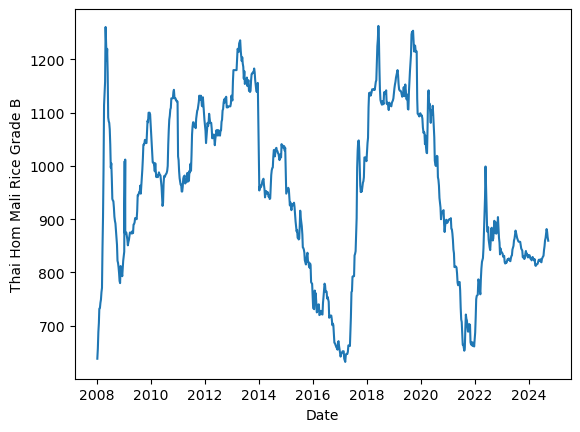

In [38]:
# Preprocess data
merged_df = pd.read_csv('../data/final_forecasted_price.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year
merged_df['Month'] = pd.to_datetime(merged_df['Date']).dt.month
# merged_df.drop(columns = ['Estimated Temperature', 'Estimated Precipitation'], inplace=True)
sns.lineplot(data = merged_df, x = 'Date', y = 'Thai Hom Mali Rice Grade B')
plt.show()



In [39]:
# Separate the data into training (2008–2022) and testing (2023–2024) based on the 'Date' column
train_data = merged_df[(merged_df['Date'] >= '2008-01-01') & (merged_df['Date'] <= '2022-12-31')]
test_data = merged_df[(merged_df['Date'] >= '2023-01-01')]

# Define X and y for training and testing
X_train = train_data.drop(columns=['White Rice 5%', 'Date'])
y_train = train_data['White Rice 5%']

X_test = test_data.drop(columns=['White Rice 5%', 'Date'])
y_test = test_data['White Rice 5%']

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the results
print("Training data shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing data shape (X_test, y_test):", X_test.shape, y_test.shape)

Training data shape (X_train, y_train): (724, 12) (724,)
Testing data shape (X_test, y_test): (78, 12) (78,)


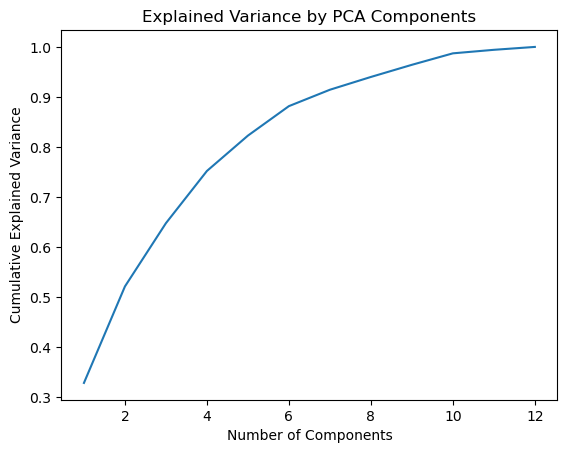

In [40]:
# Perform PCA
pca = PCA()
pca.fit(X_train_scaled)

# Explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [41]:
# 6 components is decided to be kept as it is close to around 90-95% of explained variance 
n_components = 6  
pca = PCA(n_components=n_components)
numeric_data_pca_train = pca.fit_transform(X_train_scaled)
numeric_data_pca_train

array([[-1.57715678,  2.02372865,  2.81961523, -0.57432318, -0.86534155,
        -0.09642051],
       [-1.50456631,  2.05212288,  2.8310633 , -0.55642693, -0.9032431 ,
        -0.13020014],
       [-1.31804903,  2.02510201,  2.84628792, -0.54253083, -0.91467671,
        -0.1258011 ],
       ...,
       [-0.85662627,  0.88846157,  1.13228657,  1.71014553,  2.11230986,
        -1.07234505],
       [-0.71383106,  0.7347095 ,  1.15699876,  1.69559276,  2.1361118 ,
        -1.02032292],
       [-0.68811667,  0.8265213 ,  1.15530129,  1.69447198,  2.13979378,
        -1.04248152]])

In [42]:
# Transform the test data using the already fitted PCA
numeric_data_pca_test = pca.transform(X_test_scaled)

# Check the shapes of transformed training and testing data
print("Transformed training data shape:", numeric_data_pca_train.shape)
print("Transformed test data shape:", numeric_data_pca_test.shape)

Transformed training data shape: (724, 6)
Transformed test data shape: (78, 6)


### Autoencoder

In [29]:
# Preprocess, only run this if not run earlier in PCA section
# merged_df = pd.read_csv('../data/final_forecasted_price.csv')
# merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year
# merged_df['Month'] = pd.to_datetime(merged_df['Date']).dt.month

# # Separate the data into training (2008–2022) and testing (2023–2024) based on the 'Date' column
# train_data = merged_df[(merged_df['Date'] >= '2008-01-01') & (merged_df['Date'] <= '2022-12-31')]
# test_data = merged_df[(merged_df['Date'] >= '2023-01-01')]

# # Define X and y for training and testing
# X_train = train_data.drop(columns=['White Rice 5%', 'Date'])
# y_train = train_data['White Rice 5%']

# X_test = test_data.drop(columns=['White Rice 5%', 'Date'])
# y_test = test_data['White Rice 5%']

# # Scale the training and testing data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Check the results
# print("Training data shape (X_train, y_train):", X_train.shape, y_train.shape)
# print("Testing data shape (X_test, y_test):", X_test.shape, y_test.shape)

In [54]:
# Define the autoencoder
n_features = X_train_scaled.shape[1]
encoding_dim = 6  # Number of dimensions to reduce to (similar to PCA's n_components)

# Input layer
input_layer = Input(shape=(n_features,))
# Encoding layers
encoded = Dense(16, activation='relu')(input_layer)  # Intermediate layer
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Encoded representation
# Decoding layers
decoded = Dense(16, activation='relu')(encoded)  # Intermediate layer
decoded = Dense(n_features, activation='linear')(decoded)  # Reconstructed output

In [56]:
# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model for extracting features
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [57]:
# Train the autoencoder
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
19/19 [==============================] - 1s 24ms/step - loss: 0.9928 - val_loss: 0.8706
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 0.9254 - val_loss: 0.8687
Epoch 3/50
19/19 [==============================] - 0s 2ms/step - loss: 0.8598 - val_loss: 0.8626
Epoch 4/50
19/19 [==============================] - 0s 2ms/step - loss: 0.7844 - val_loss: 0.8560
Epoch 5/50
19/19 [==============================] - 0s 2ms/step - loss: 0.7161 - val_loss: 0.8496
Epoch 6/50
19/19 [==============================] - 0s 2ms/step - loss: 0.6509 - val_loss: 0.8382
Epoch 7/50
19/19 [==============================] - 0s 2ms/step - loss: 0.5995 - val_loss: 0.8204
Epoch 8/50
19/19 [==============================] - 0s 2ms/step - loss: 0.5557 - val_loss: 0.7987
Epoch 9/50
19/19 [==============================] - 0s 2ms/step - loss: 0.5204 - val_loss: 0.7757
Epoch 10/50
19/19 [==============================] - 0s 2ms/step - loss: 0.4884 - val_loss: 0.7584
Epoch 11/50
19/19 

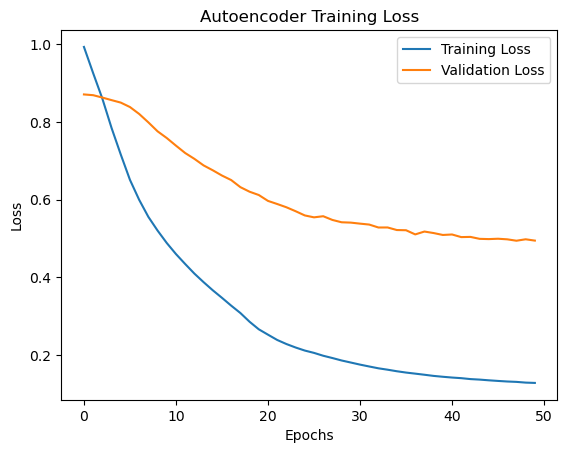

In [58]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()

In [59]:
# Transform the training and test data using the encoder
numeric_data_autoencoder_train = encoder.predict(X_train_scaled)
numeric_data_autoencoder_test = encoder.predict(X_test_scaled)

# Check the shapes of transformed training and testing data
print("Transformed training data shape:", numeric_data_autoencoder_train.shape)
print("Transformed test data shape:", numeric_data_autoencoder_test.shape)


3/3 [==============================] - 0s 5ms/step
Transformed training data shape: (724, 6)
Transformed test data shape: (78, 6)


# Perform Thailand White Rice 5% Price Prediction (Supervised Learning Task)
This is a regression task
Three methods will be explored:
* Ridge Regression
* Random Forest 
* Long-Short Term Memory (LSTM)


### Ridge Regression (Future Forecast)

In [60]:
# alpha value optimisation with cross validation
# Define range of alpha values for cross-validation
alphas = np.logspace(-6, 6, 13)  # From 1e-6 to 1e6

# Ridge Regression with cross-validated alpha selection
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)  # Using 5-fold CV
# ridge_cv.fit(numeric_data_pca_train, y_train)  # PCA
ridge_cv.fit(numeric_data_autoencoder_train, y_train) # Autoencoder
# ridge_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha = ridge_cv.alpha_
print(f"Best alpha value found from cross-validation: {best_alpha}")
print(numeric_data_pca_train.shape, y_train.shape)
print(numeric_data_pca_test.shape, y_test.shape)

Best alpha value found from cross-validation: 1e-05
(724, 6) (724,)
(78, 6) (78,)


In [61]:
# Make predictions on training data
# y_pred = ridge_cv.predict(numeric_data_pca_test) # PCA
y_pred = ridge_cv.predict(numeric_data_autoencoder_test) # Autoencoder
# y_pred = ridge_cv.predict(X_test)


# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

RMSE: 128.48972781558248
MAE: 116.6901104266827
R^2 Score: -4.0252664589882965


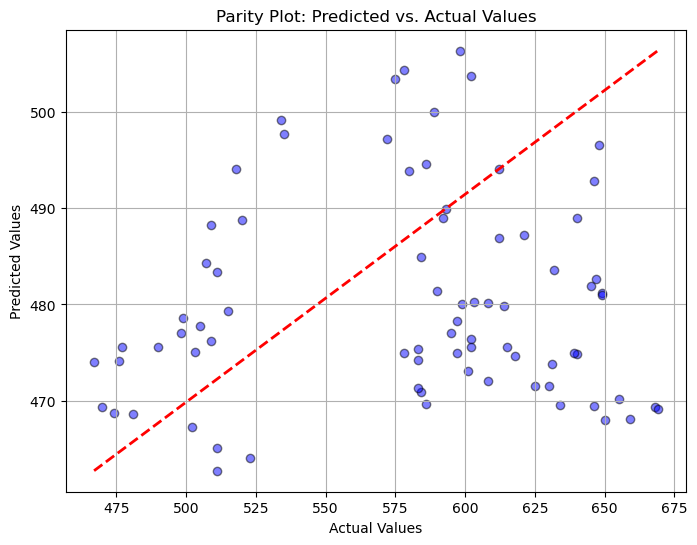

In [37]:
# Parity plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Predicted vs. Actual Values')
plt.grid()
plt.show()

### Ridge Regression (Current Forecast)

In [251]:
merged_df = pd.read_csv('../data/final_forecasted_price.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year
merged_df['Month'] = pd.to_datetime(merged_df['Date']).dt.month

# Separate the data into training (2008–2022) and testing (2023–2024) based on the 'Date' column
train_data_current = merged_df[(merged_df['Date'] >= '2008-01-01') & (merged_df['Date'] <= '2020-12-31')]
test_data_current = merged_df[(merged_df['Date'] >= '2021-01-01') & (merged_df['Date'] <= '2022-12-31')]

# Define X and y for training and testing
X_train_current = train_data_current.drop(columns=['White Rice 5%', 'Date'])
y_train_current = train_data_current['White Rice 5%']

X_test_current = test_data_current.drop(columns=['White Rice 5%', 'Date'])
y_test_current = test_data_current['White Rice 5%']

In [252]:
# alpha value optimisation with cross validation
# Define range of alpha values for cross-validation
alphas = np.logspace(-6, 6, 13)  # From 1e-6 to 1e6

# Ridge Regression with cross-validated alpha selection
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)  # Using 5-fold CV
# ridge_cv.fit(numeric_data_pca_train, y_train)  # PCA
# ridge_cv.fit(numeric_data_autoencoder_train, y_train) # Autoencoder
ridge_cv.fit(X_train_current, y_train_current)

# Get the best alpha
best_alpha = ridge_cv.alpha_
print(f"Best alpha value found from cross-validation: {best_alpha}")

Best alpha value found from cross-validation: 1000.0


In [253]:
# Make predictions on training data
# y_pred = ridge_cv.predict(numeric_data_pca_test) # PCA
# y_pred = ridge_cv.predict(numeric_data_autoencoder_test) # Autoencoder
y_pred = ridge_cv.predict(X_test_current)


# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_current, y_pred))
mae = mean_absolute_error(y_test_current, y_pred)
r2 = r2_score(y_test_current, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

RMSE: 6.626719850054937
MAE: 5.3362706388754875
R^2 Score: 0.9785065915817047


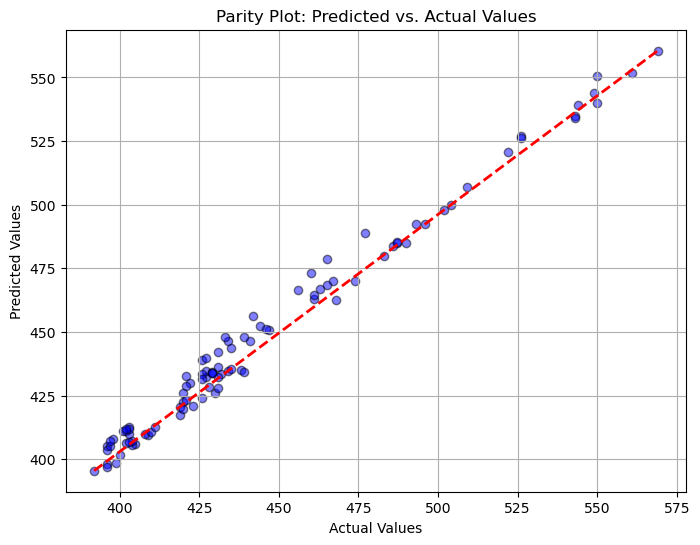

In [255]:
# Parity plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_current, y_pred, color='blue', alpha=0.5, edgecolor='k')
plt.plot([min(y_test_current), max(y_test_current)], [min(y_pred), max(y_pred)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Predicted vs. Actual Values')
plt.grid()
plt.show()

### Random Forest (Future Forecast)

In [260]:
# Hyperparameter grid to be tuned
param_grid = {
    'n_estimators': [50, 100, 200, 500, 700],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [63]:
# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV on the PCA-transformed data
# grid_search.fit(numeric_data_pca_train, y_train) # PCA
# grid_search.fit(numeric_data_autoencoder_train, y_train) # Autoencoder
grid_search.fit(X_train, y_train)

# Best model and parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best parameters found: {best_params}")

c:\Users\Chappyyyyyy\anaconda3\envs\keras\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [65]:
# Make predictions on training data
# y_pred = best_rf.predict(numeric_data_pca_test)
# y_pred = best_rf.predict(numeric_data_autoencoder_test) # Autoencoder
y_pred = best_rf.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

RMSE: 129.02487153121638
MAE: 113.40633634608457
R^2 Score: -4.067212846222413


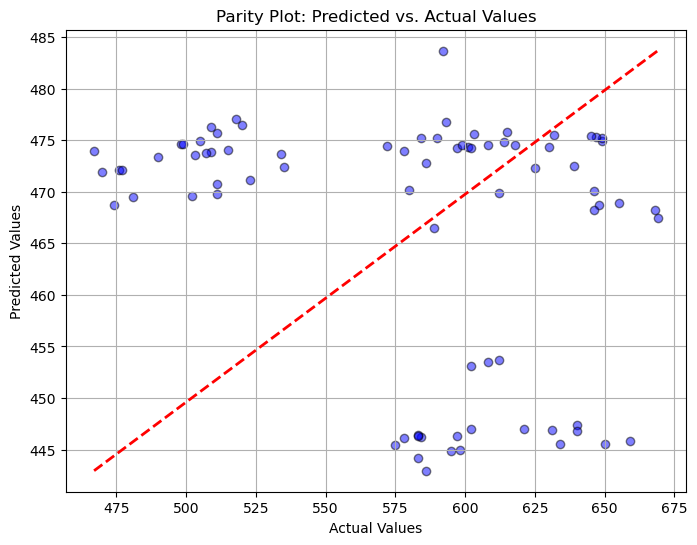

In [66]:
# Parity plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Predicted vs. Actual Values')
plt.grid()
plt.show()


In [ ]:
# Save the best model to the specified path
model_path = '../other/best_rf_model.joblib'
joblib.dump(best_rf, model_path)

print(f"Model saved to {model_path}")


Model saved to ../other/best_rf_model.joblib


In [ ]:
# Load the saved model
best_rf = joblib.load('../other/best_rf_model.joblib')


### Random Forest (Current Forecast)

In [261]:
# Initialize Random Forest model
rf = RandomForestRegressor(random_state=420)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV on the PCA-transformed data
# grid_search.fit(numeric_data_pca_train, y_train) # PCA
# grid_search.fit(numeric_data_autoencoder_train, y_train) # Autoencoder
grid_search.fit(X_train_current, y_train_current)

# Best model and parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best parameters found: {best_params}")

Best parameters found: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


c:\Users\Chappyyyyyy\anaconda3\envs\keras\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [262]:
# Make predictions on training data
# y_pred = best_rf.predict(numeric_data_pca_test)
# y_pred = best_rf.predict(numeric_data_autoencoder_test) # Autoencoder
y_pred = best_rf.predict(X_test_current)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_current, y_pred))
mae = mean_absolute_error(y_test_current, y_pred)
r2 = r2_score(y_test_current, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

RMSE: 10.356804068034885
MAE: 9.238238470163578
R^2 Score: 0.947499965342187


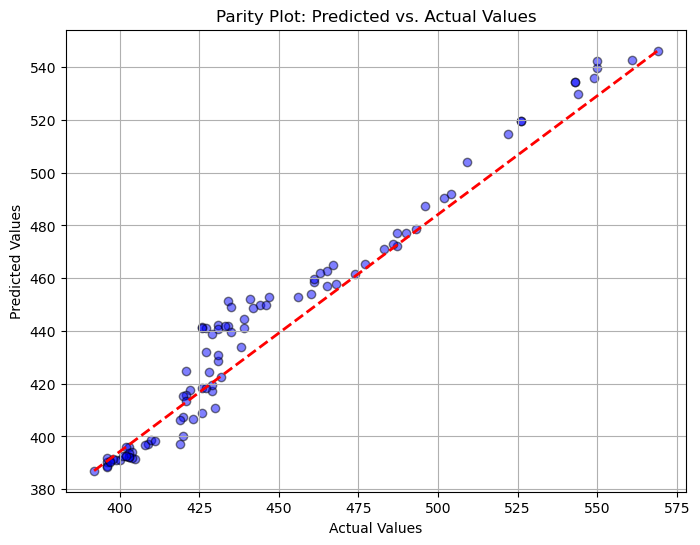

In [263]:
# Parity plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_current, y_pred, color='blue', alpha=0.5, edgecolor='k')
plt.plot([min(y_test_current), max(y_test_current)], [min(y_pred), max(y_pred)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Predicted vs. Actual Values')
plt.grid()
plt.show()


In [ ]:
# Save the best model to the specified path
model_path = '../other/best_rf_model2.joblib'
joblib.dump(best_rf, model_path)

print(f"Model saved to {model_path}")

In [ ]:
# Load the saved model
best_rf = joblib.load('../other/best_rf_model2.joblib')

### LSTM Model

In [231]:
data = pd.read_csv('../data/future_rice.csv')

# Convert 'Date' column to datetime if it isn't already
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data.set_index('Date', inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)

data_test = data[(data.index >= '2023-01-01')]
data_test = data_test['White Rice 5%']
data_test_list = data_test.tolist()
data = data[(data.index >= '2008-01-01') & (data.index <= '2022-12-31')]
print(len(data[(data.index >= '2008-01-01') & (data.index <= '2020-12-31')])/len(data)) # to determine how much training and testing data needed
print(data_test.shape, data.shape)
data

0.8660220994475138
(78,) (724, 12)


,Ex Rate (sight bill),Thai Hom Mali Rice Grade B,White Broken Rice A.1 Super,White Glutinous Rice 10%,Parboiled Rice 100%,Estimated Temperature,Estimated Precipitation,Vietnam_White_5%,India_White_5%,Pakistan_White_5%,White Rice 5%,Month
Date,,,,,,,,,,,,
2008-01-09,33.05,638.0,361.0,558.0,398.0,23.595159,280.667674,390.0,345.633484,390.0,374.0,1
2008-01-16,33.00,657.0,365.0,529.0,404.0,23.595159,280.667674,390.0,345.633484,390.0,377.0,1
2008-01-23,32.94,688.0,378.0,514.0,420.0,23.595159,280.667674,390.0,345.633484,390.0,387.0,1
2008-01-30,32.86,705.0,403.0,510.0,440.0,23.595159,280.667674,390.0,345.633484,390.0,418.0,1
2008-02-05,32.73,732.0,429.0,518.0,466.0,25.259548,215.285593,467.0,345.633484,478.0,444.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23,35.92,865.0,403.0,698.0,453.0,25.490990,1125.129626,438.0,387.000000,432.0,442.0,11
2022-11-30,35.10,856.0,412.0,728.0,464.0,25.490990,1125.129626,438.0,387.000000,432.0,456.0,11
2022-12-07,34.80,834.0,415.0,735.0,468.0,23.845445,588.910824,456.0,388.000000,456.0,460.0,12


In [232]:
# Separate predictors and target
features = data # Replace with your predictors
target = data

# Split data into train and test sets
train_size = int(len(features) * 0.866)  # 86% training, 14% testing
features_train, features_test = features[:train_size], features[train_size:]
target_train, target_test = target[:train_size], target[train_size:]

# Scale predictors and target separately
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_train_scaled = scaler_features.fit_transform(features_train)
features_test_scaled = scaler_features.transform(features_test)  # Use the same scaler as training

target_train_scaled = scaler_target.fit_transform(target_train)
target_test_scaled = scaler_target.transform(target_test)  # Use the same scaler as training
print(features_test_scaled, target_train_scaled.shape)


[[0.16440217 0.41362916 0.34980237 ... 0.20779221 0.26636905 1.        ]
 [0.13451087 0.42313788 0.35573123 ... 0.24304267 0.28720238 0.        ]
 [0.13179348 0.42472266 0.34387352 ... 0.24304267 0.28720238 0.        ]
 ...
 [0.82201087 0.32012678 0.23715415 ... 0.2690167  0.16369048 1.        ]
 [0.76222826 0.33755943 0.24901186 ... 0.2690167  0.17113095 1.        ]
 [0.78668478 0.3296355  0.25494071 ... 0.2690167  0.1889881  1.        ]] (626, 12)


In [233]:
def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

In [234]:
# Define time steps
time_steps = 32  # Number of past steps to use for prediction 25,20,32

# Create sequences
X_train, y_train = create_sequences(features_train_scaled, target_train_scaled, time_steps)
X_test, y_test = create_sequences(features_test_scaled, target_test_scaled, time_steps)
print(X_test.shape, y_test.shape)

(66, 32, 12) (66, 12)


In [235]:
# Hyperparameter Tuning
def build_model(hp):
    model = Sequential()
    
    # Tune number of units in the first LSTM layer
    model.add(LSTM(
        units=hp.Int('units_layer1', min_value=32, max_value=128, step=32),
        return_sequences=True,  # Ensure sequences are returned for stacking more layers
        input_shape=(time_steps, X_train.shape[2])
    ))
    
    # Tune number of units in the second LSTM layer
    model.add(LSTM(
        units=hp.Int('units_layer2', min_value=16, max_value=64, step=16),
        return_sequences=False  # Allow another LSTM layer to follow
    ))
    
    # # Tune number of units in the third LSTM layer
    # model.add(LSTM(
    #     units=hp.Int('units_layer3', min_value=16, max_value=64, step=16),
    #     return_sequences=False  # Last LSTM layer, no need to return sequences
    # ))
    
    # Add dense output layer
    model.add(Dense(12))
    
    # Tune learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# Initialize KerasTuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='new_dir3',
    project_name='lstm_tuning_extra_layer'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Run the tuner search
tuner.search(X_train, y_train, validation_data=(X_test, y_test), 
             epochs=50, batch_size=2, callbacks=[early_stopping], verbose=1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units_layer1')} units.
The optimal number of units in the second LSTM layer is {best_hps.get('units_layer2')} units.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 63 Complete [00h 00m 22s]
val_loss: 0.007478306535631418

Best val_loss So Far: 0.005503125488758087
Total elapsed time: 00h 20m 41s

The optimal number of units in the first LSTM layer is 96 units.
The optimal number of units in the second LSTM layer is 16 units.
The optimal learning rate for the optimizer is 0.01.



In [236]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=2, callbacks=[early_stopping], verbose=1)


Epoch 1/100
297/297 [==============================] - 7s 15ms/step - loss: 0.0232 - mae: 0.1072 - val_loss: 0.0140 - val_mae: 0.0853
Epoch 2/100
297/297 [==============================] - 4s 12ms/step - loss: 0.0086 - mae: 0.0648 - val_loss: 0.0119 - val_mae: 0.0834
Epoch 3/100
297/297 [==============================] - 4s 12ms/step - loss: 0.0066 - mae: 0.0557 - val_loss: 0.0113 - val_mae: 0.0788
Epoch 4/100
297/297 [==============================] - 4s 13ms/step - loss: 0.0059 - mae: 0.0523 - val_loss: 0.0102 - val_mae: 0.0769
Epoch 5/100
297/297 [==============================] - 4s 13ms/step - loss: 0.0054 - mae: 0.0486 - val_loss: 0.0083 - val_mae: 0.0663
Epoch 6/100
297/297 [==============================] - 4s 13ms/step - loss: 0.0050 - mae: 0.0468 - val_loss: 0.0081 - val_mae: 0.0639
Epoch 7/100
297/297 [==============================] - 4s 13ms/step - loss: 0.0057 - mae: 0.0483 - val_loss: 0.0111 - val_mae: 0.0766
Epoch 8/100
297/297 [==============================] - 4s 12ms

In [237]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Test Loss: 0.0063574546948075294, Test MAE: 0.06021222844719887


In [238]:
model.save('../other/lstm_model4.h5')

In [239]:
# load model
model = load_model('../other/lstm_model4.h5')

In [240]:
def forecast_future(features, model, time_steps, steps_to_forecast=78):
    predictions = []
    input_sequence = features[-time_steps:]  # Start with the last known sequence

    for _ in range(steps_to_forecast):
        # Reshape input_sequence to match the model's expected input shape
        input_sequence_reshaped = np.expand_dims(input_sequence, axis=0)  # Shape: (1, time_steps, features)

        # Predict the next time step for all variables (both predictors and target)
        predicted_values = model.predict(input_sequence_reshaped, verbose=0)[0]  # Shape: (features,)

        # Append the predicted target value to the predictions list
        predictions.append(predicted_values[-2])  # Assuming the second last value is the target ("White Rice 5%")

        # Update the input sequence for the next step
        input_sequence = np.vstack([input_sequence[1:], predicted_values])
    
    return predictions


In [241]:
final_scaler = MinMaxScaler()
white_rice_5 = data['White Rice 5%']
white_rice_5_scaled = final_scaler.fit_transform(white_rice_5.values.reshape(-1, 1))

In [242]:
predictions_scaled = forecast_future(features_scaled, model, time_steps, steps_to_forecast=78)
predictions_original_scale = final_scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
predictions_original_scale

array([490.47623, 483.40387, 485.9518 , 494.5121 , 498.1858 , 508.2992 ,
       514.85834, 516.76874, 516.60474, 513.90247, 508.5145 , 500.65823,
       490.60126, 478.60376, 465.0561 , 450.515  , 435.69412, 421.40274,
       408.4726 , 397.68262, 389.66858, 384.84323, 383.32098, 384.8436 ,
       388.80035, 394.31577, 400.4735 , 406.48904, 411.8421 , 416.3071 ,
       419.83072, 422.68964, 425.41266, 428.0848 , 430.72333, 433.561  ,
       436.59213, 439.71133, 442.93338, 446.23346, 449.62482, 453.1897 ,
       457.09167, 461.63312, 467.31815, 474.90442, 485.30365, 498.90625,
       513.75006, 522.8566 , 515.879  , 503.223  , 511.89975, 516.5512 ,
       524.07825, 535.92163, 552.4449 , 565.7309 , 571.38055, 570.7636 ,
       564.8503 , 554.74536, 541.67255, 526.8814 , 511.57922, 496.87753,
       483.75803, 473.0335 , 465.28918, 460.80057, 459.4565 , 460.744  ,
       463.8421 , 467.82068, 471.85507, 475.36255, 478.03296, 479.79813],
      dtype=float32)

In [243]:
# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(data_test_list, predictions_original_scale))
mae = mean_absolute_error(data_test_list, predictions_original_scale)
r2 = r2_score(data_test_list, predictions_original_scale)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

RMSE: 128.78945403561886
MAE: 113.02020146296574
R^2 Score: -4.048738543440145


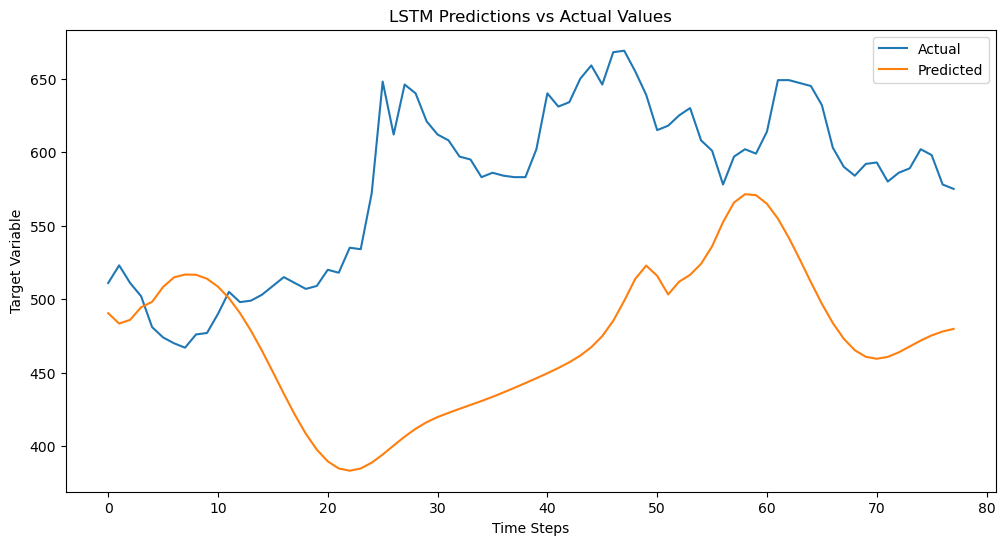

In [264]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(data_test_list)), data_test_list, label='Actual')
plt.plot(range(len(predictions_original_scale)), predictions_original_scale, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Target Variable')
plt.title('LSTM Predictions vs Actual Values')
plt.legend()
plt.show()

## Perform Clustering (Archived) (Programming Assignment 2)

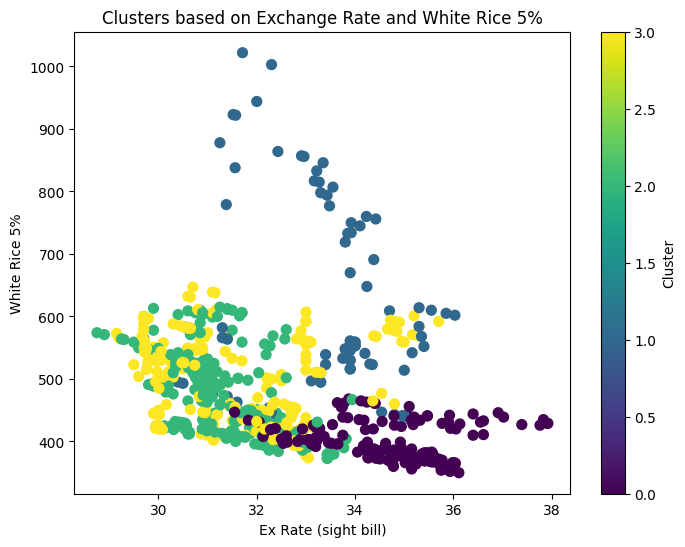

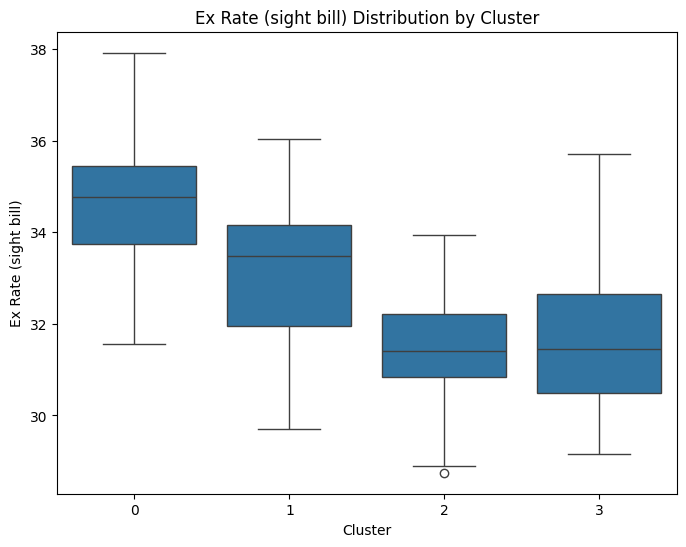

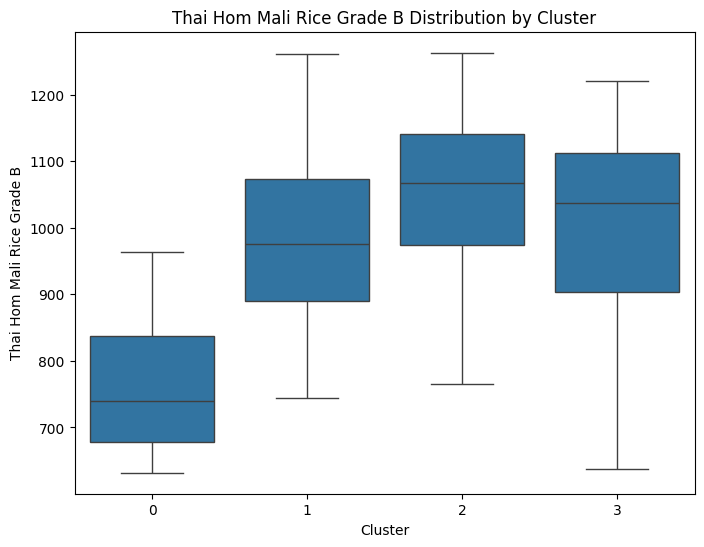

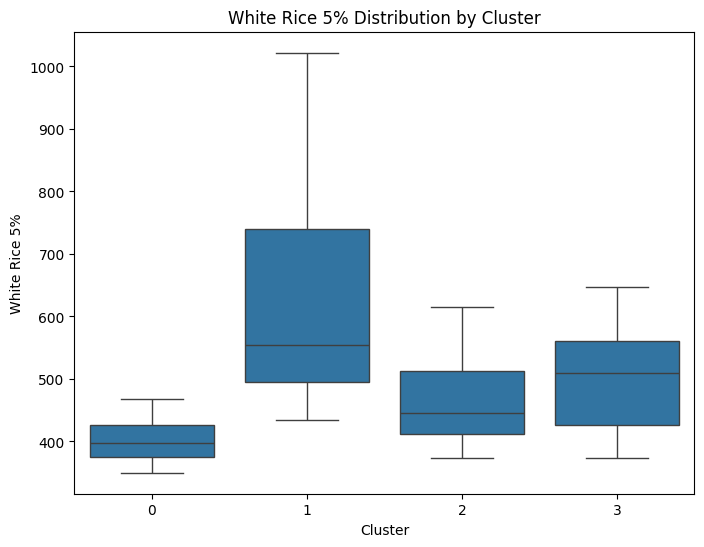

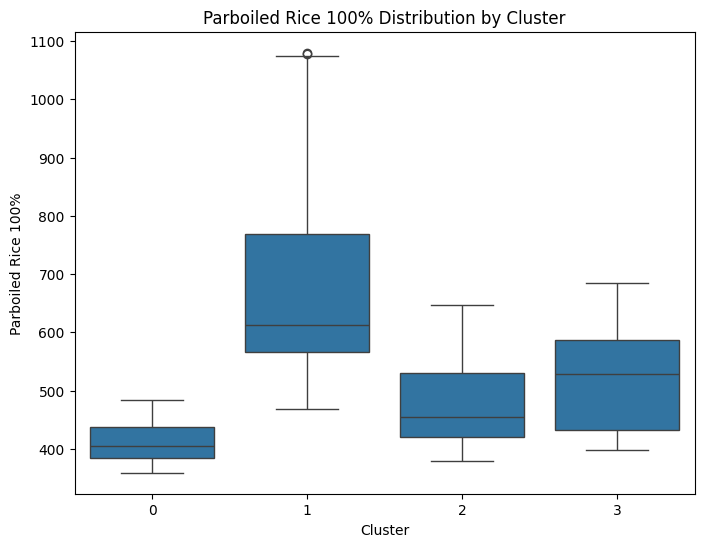

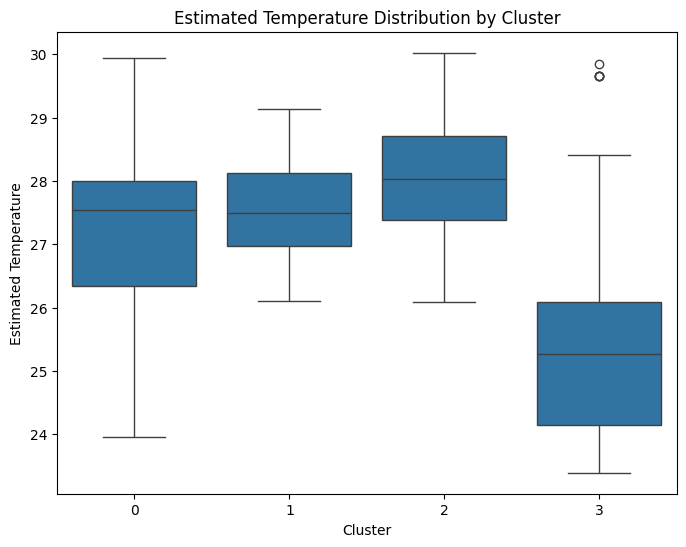

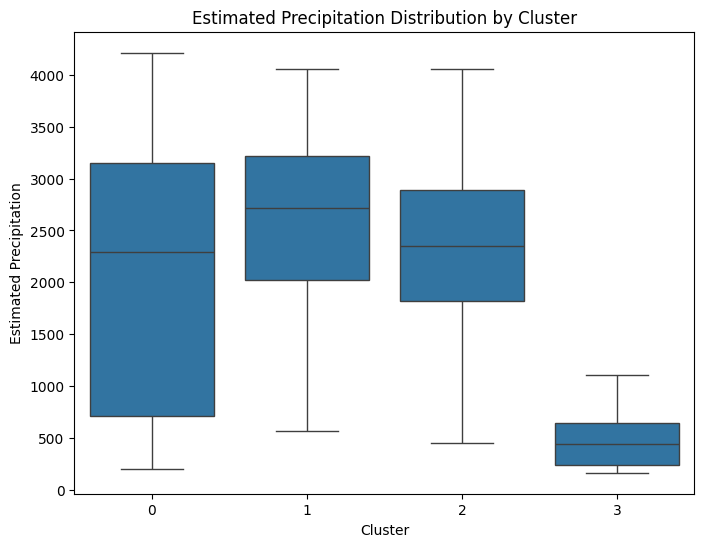

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame `df`
# Select the columns for GMM
features = ['Ex Rate (sight bill)', 'Thai Hom Mali Rice Grade B', 'White Rice 5%', 
            'Parboiled Rice 100%', 'Estimated Temperature', 'Estimated Precipitation']
X = merged_df[features].dropna()  # Drop rows with missing values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the GMM model
gmm = GaussianMixture(n_components=4, random_state=0)  # Adjust n_components as needed
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)


# Add labels to the original DataFrame
merged_df['Cluster'] = labels

# too much graph hard to interpret
# sns.pairplot(merged_df[features + ['Cluster']], hue='Cluster', palette='viridis')
# plt.show()
# graph of cluster with just exchange rate and white rice 5% 
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Ex Rate (sight bill)'], merged_df['White Rice 5%'], c=merged_df['Cluster'], cmap='viridis', s=50)
plt.title('Clusters based on Exchange Rate and White Rice 5%')
plt.xlabel('Ex Rate (sight bill)')
plt.ylabel('White Rice 5%')
plt.colorbar(label='Cluster')
plt.show()

# boxplot of each cluster for each component
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cluster', y=feature, data=merged_df)
    plt.title(f'{feature} Distribution by Cluster')
    plt.show()


## Cluster Analysis of Rice Prices, Exchange Rates, and Weather Conditions (Insights based on the cluster visualisations above)

### Cluster 0:
- **Rice Prices**: Cluster 0 generally has **significantly lower rice prices** across all types than other clusters, indicating that this cluster represents a period of relatively low demand or high supply for rice.
- **Exchange Rate**: The **exchange rate is at its highest** in this cluster, suggesting that the Thai Baht was stronger during this period. A higher exchange rate can mean that the economy was facing challenges, which could lead to lower rice prices as domestic demand decreases.
- **Temperature & Precipitation**: The **temperature and precipitation** in this cluster have wide ranges, indicating that this phenomenon occurs across different seasons. The economic conditions likely have more impact on rice prices than seasonal factors.

**Conclusion for Cluster 0:**  
High exchange rates and lower rice prices suggest this cluster might reflect periods of economic struggle, where demand for rice is low, and this condition is spread across various times of the year, regardless of weather conditions in Thailand.

---

### Cluster 1:
- **Rice Prices**: Cluster 1 has a **very high price range** for **White Rice 5%**, especially, which could correspond to periods of crisis, such as the **2008 food crisis**. Prices for other rice types also tend to be higher in this cluster.
- **Exchange Rate**: The **exchange rate** in this cluster is **moderate**, suggesting it is not a dominant factor in driving rice prices.
- **Temperature & Precipitation**: The **temperature range is lower** than Cluster 0, and the temperatures are relatively high, which suggests that this cluster may represent periods around the **dry season to the early monsoon season**. The **precipitation range is large**, aligning with the transition from the dry to monsoon seasons.

**Conclusion for Cluster 1:**  
This cluster likely reflects periods where external factors, such as global food crises, drive prices higher, with the seasonality playing a secondary role. The transition from the dry to monsoon seasons could be impacting production or supply.

---

### Cluster 2:
- **Rice Prices**: Cluster 2 has **low prices for White Rice 5%** but **high prices for Thai Hom Mali rice**. This indicates that there is a divergence in demand or supply between different rice types.
- **Exchange Rate**: The **exchange rate is the lowest** in this cluster, suggesting a weak Thai Baht. This low exchange rate might lead to higher export competitiveness for some rice types (like Thai Hom Mali rice) while domestic prices for other types remain relatively lower.
- **Temperature & Precipitation**: The **temperature is at its highest**, likely around the end of the **dry season (Songkran)**. Precipitation levels are also relatively high, indicating the late dry season or early monsoon season.

**Conclusion for Cluster 2:**  
This cluster might represent a period where a weak exchange rate makes Thai Hom Mali rice more attractive in international markets, increasing its price due to higher export demand. At the same time, the price of White Rice 5% remains relatively low, possibly because it faces more competition in global markets and is more sensitive to price changes. The timing near the end of the dry season could also affect agricultural cycles, contributing to these price differences.

---

### Cluster 3:
- **Rice Prices**: Rice prices (White Rice 5%, Thai Hom Mali) in this cluster are more **middle-range**, indicating no extreme spikes or dips.
- **Exchange Rate**: The **exchange rate is moderate**, suggesting stable economic conditions during this period.
- **Temperature & Precipitation**: This cluster shows the **lowest temperature and precipitation**, suggesting it corresponds to the **cool season (Winter)** in Thailand.

**Conclusion for Cluster 3:**  
This cluster represents periods with stable, average rice prices and weather conditions. The lower temperatures and precipitation suggest this cluster represents data from the cool season, where rice prices remain steady.

---

### Final Observations:
- **Cluster 0** reflects periods of low rice prices, likely driven by high exchange rates.
- **Cluster 1** corresponds to periods of high rice prices, particularly during global crises, with moderate exchange rates.
- **Cluster 2** shows contrasting trends, with high Thai Hom Mali prices and low White Rice 5% prices, driven by weak exchange rates and seasonal factors.
- **Cluster 3** represents stable prices and cool season conditions.

This analysis highlights the complex interplay between economic factors (exchange rates) and seasonal/weather conditions in determining rice prices across clusters.


### Archived for now

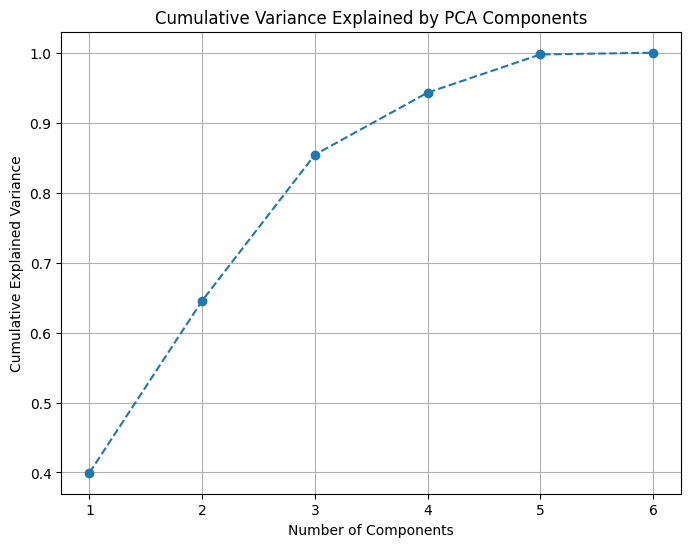

In [ ]:
# PCA explained variance
pca = PCA().fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

# Plot the cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

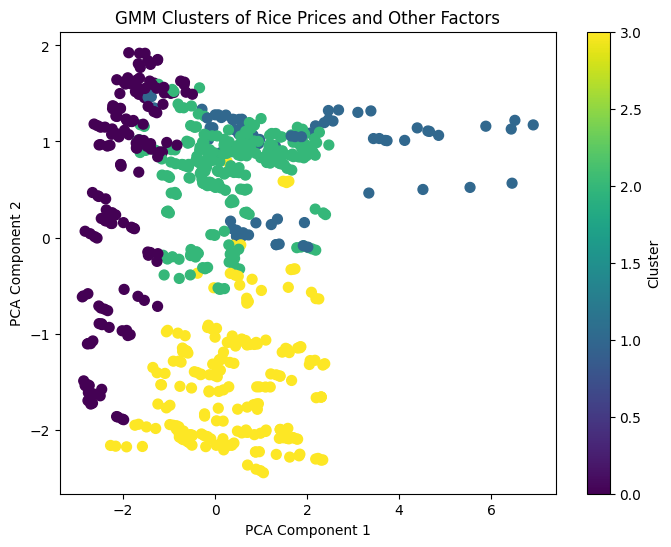

In [ ]:
# Reduce the dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('GMM Clusters of Rice Prices and Other Factors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

<!-- K-Means Clustering is selected because:
* It is computationally efficient and simple to implement
* It is effective at capturing pattern based on numerical features
* Assist in interpreting relationship between variables -->

In [ ]:
#K-means scattering code (archived for now as GMM used instead)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select only relevant rice types and external factors for clustering
features = ['White Rice 5%', 'Thai Hom Mali Rice Grade B', 'Parboiled Rice 100%', 'Ex Rate (sight bill)']
X = df[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
print(df.groupby('Cluster').mean())


                                 Date  Ex Rate (sight bill)  \
Cluster                                                       
0       2018-03-28 00:48:12.050209280             34.105439   
1       2016-10-08 01:54:17.142857216             34.723016   
2       2008-06-27 23:00:00.000000000             32.872917   
3       2015-07-15 00:52:18.014527744             31.201816   

         Thai Hom Mali Rice Grade B  White Rice 5%  \
Cluster                                              
0                        794.523013     409.246862   
1                        898.126984     586.222222   
2                       1041.333333     838.250000   
3                       1068.150121     488.704600   

         White Broken Rice A.1 Super  White Glutinous Rice 10%  \
Cluster                                                          
0                         361.238494                731.443515   
1                         410.857143                675.880952   
2                         630.54

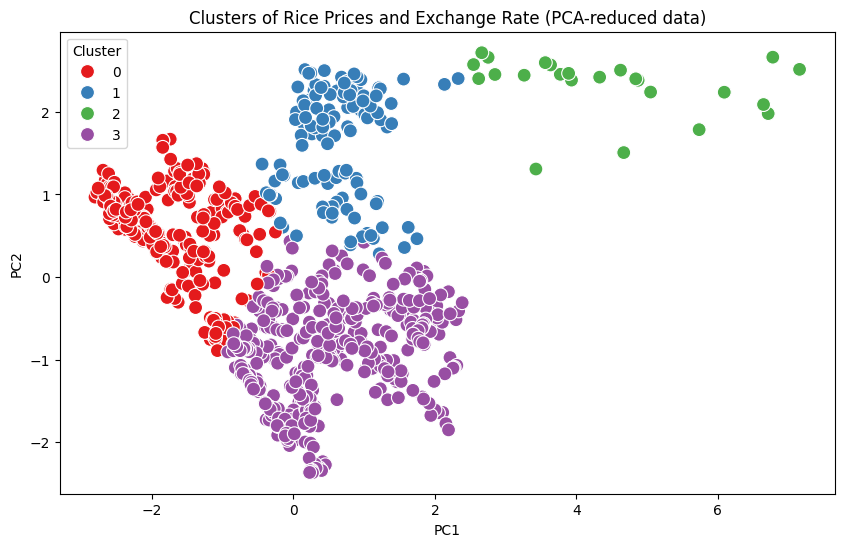

In [ ]:
# Visualisation of the cluster using PCA
from sklearn.decomposition import PCA

# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a new DataFrame for visualization
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100)
plt.title('Clusters of Rice Prices and Exchange Rate (PCA-reduced data)')
plt.show()